#DS 5983 - PA3 - Hugging Face Transformers

**Installing the required libraries**

In [1]:
!pip install transformers
!pip install datasets
!pip install accelerate
!pip install rouge_score
!pip install nltk
!pip install evaluate
!pip install accelerate
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=de6edab5083613cdb568ba921d939420a3c514d02ef363c37fc285dae4a8bfdc
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00


In [3]:
!pip install tensorflow --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


**Importing the required libaries and functions.**

In [2]:
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
from nltk.tokenize import word_tokenize, sent_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import DataCollatorForSeq2Seq
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import corpus_bleu
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
import evaluate
from tqdm import tqdm
from collections import Counter
import re
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**Loading the Samsum corpus from the hugging face hub.**

In [3]:
dataset = load_dataset("samsum")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

In [4]:
print(dataset) #Printing the dataset to see what it looks like

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})


#1. Exploratory Data Analysis:

###1.1  Conduct an initial exploration of the SAMSum dataset to gain insights into the characteristics of the dialogues and summaries

In [24]:
# Divide the dataset into train, test and validation dataset
train_dataset = pd.DataFrame(dataset['train'])
test_dataset = pd.DataFrame(dataset['test'])
validation_dataset = pd.DataFrame(dataset['validation'])

In [5]:
#Checking total rows and columns in each split
print(train_dataset.shape)
print(test_dataset.shape)
print(validation_dataset.shape)

(14732, 3)
(819, 3)
(818, 3)


**1.1.1 Checking for null values in each dataset.**

In [6]:
print("\nChecking for null values in the training dataset")
print(train_dataset.isnull().sum())
print("\nChecking for null values in the testing dataset")
print(test_dataset.isnull().sum())
print("\nChecking for null values in the validation dataset")
print(validation_dataset.isnull().sum())


Checking for null values in the training dataset
id          0
dialogue    0
summary     0
dtype: int64

Checking for null values in the testing dataset
id          0
dialogue    0
summary     0
dtype: int64

Checking for null values in the validation dataset
id          0
dialogue    0
summary     0
dtype: int64


**There are no null values in the dataset.**

**most common 10 words in dialogue and summaries**

In [15]:
def find_common_words(dataset):
  # Combine dialogue and summary text from the dataset
  combined_text = ' '.join(dataset['dialogue'] + ' ' + dataset['summary'])

  # Tokenize the combined text into words (you can adjust the tokenizer based on your specific needs)
  words = re.findall(r'\b\w+\b', combined_text.lower())

  # Calculate the frequency of each word
  word_counts = Counter(words)

  # Find the most common 10 words
  most_common_words = word_counts.most_common(10)

  return most_common_words

In [16]:
# Find the most common words in the training data
most_common_words = find_common_words(train_dataset)

# Print or use the most common words as needed
print("Most Common 10 Words in the Training Data:")
for word, count in most_common_words:
    print(f"{word}: {count}")

Most Common 10 Words in the Training Data:
i: 60692
you: 42963
the: 42340
to: 40844
it: 30921
a: 29822
and: 27898
s: 24421
is: 18193
t: 17416


In [17]:
# Find the most common words in the testing data
most_common_words = find_common_words(test_dataset)

# Print or use the most common words as needed
print("Most Common 10 Words in the Testing Data:")
for word, count in most_common_words:
    print(f"{word}: {count}")

Most Common 10 Words in the Testing Data:
i: 3403
you: 2343
the: 2335
to: 2249
it: 1699
a: 1691
and: 1610
s: 1431
is: 1018
t: 955


In [18]:
# Find the most common words in the validation data
most_common_words = find_common_words(validation_dataset)

# Print or use the most common words as needed
print("Most Common 10 Words in the validation Data:")
for word, count in most_common_words:
    print(f"{word}: {count}")

Most Common 10 Words in the validation Data:
i: 3223
the: 2326
you: 2243
to: 2189
it: 1705
a: 1614
and: 1509
s: 1345
is: 1026
for: 963


**longest dialogue length**

**longest summary length**

**shortest dialogue length**

**shortest summary length**

**of all datasets.**

In [9]:
#Finding the length of the dialogies and summaries in the training data.
train_dataset['dialogue length'] = train_dataset['dialogue'].apply(len)
train_dataset['summary length'] = train_dataset['summary'].apply(len)

#Finding the length of the dialogies and summaries in the validation data.
validation_dataset['dialogue length'] = validation_dataset['dialogue'].apply(len)
validation_dataset['summary length'] = validation_dataset['summary'].apply(len)

#Finding the length of the dialogies and summaries in the testing data.
test_dataset['dialogue length'] = test_dataset['dialogue'].apply(len)
test_dataset['summary length'] = test_dataset['summary'].apply(len)

In [10]:
print("\nTraining data - dialogue statistics")
print(train_dataset['dialogue length'].describe())
print("\nTraining data - summary statistics")
print(train_dataset['summary length'].describe())

print("\nValidation data - dialogue statistics")
print(validation_dataset['dialogue length'].describe())
print("\nValidation data - summary statistics")
print(validation_dataset['summary length'].describe())

print("\nTesting data - dialogue statistics")
print(test_dataset['dialogue length'].describe())
print("\nTesting data - summary statistics")
print(test_dataset['summary length'].describe())


Training data - dialogue statistics
count    14732.000000
mean       511.183614
std        402.621436
min          0.000000
25%        216.000000
50%        401.000000
75%        694.000000
max       5492.000000
Name: dialogue length, dtype: float64

Training data - summary statistics
count    14732.000000
mean       110.134673
std         60.892471
min          3.000000
25%         63.000000
50%         96.000000
75%        144.000000
max        300.000000
Name: summary length, dtype: float64

Validation data - dialogue statistics
count     818.000000
mean      499.396088
std       403.632584
min        57.000000
25%       208.000000
50%       385.500000
75%       688.000000
max      2950.000000
Name: dialogue length, dtype: float64

Validation data - summary statistics
count    818.000000
mean     110.174817
std       61.388822
min       17.000000
25%       63.000000
50%       96.000000
75%      144.000000
max      300.000000
Name: summary length, dtype: float64

Testing data - dial

###1.2 Plotting the lengths of dialogues and summaries for the data

**Plotting the length distribution of dialogues and summaries in the training data.**

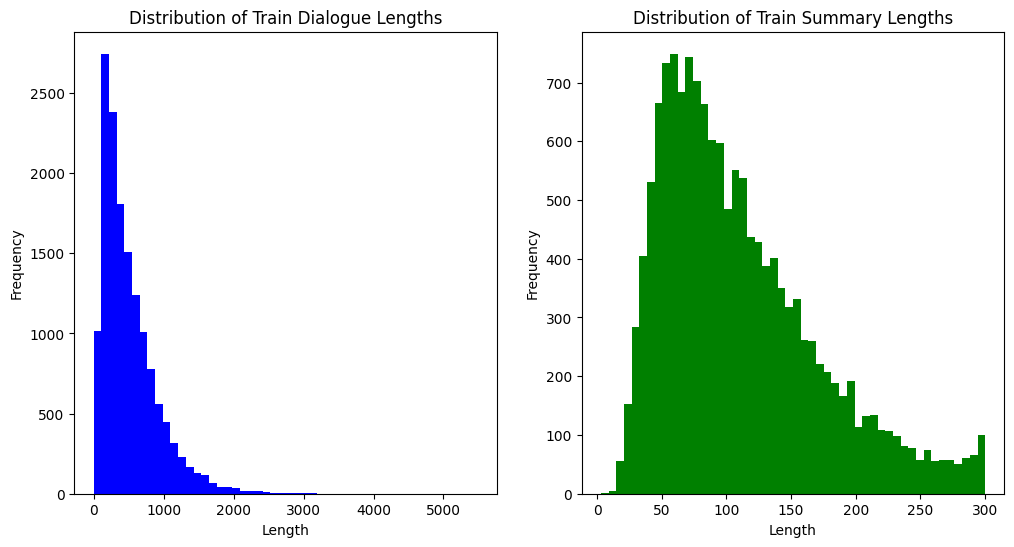

In [11]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_dataset['dialogue length'], bins=50, color='blue')
plt.title('Distribution of Train Dialogue Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(train_dataset['summary length'], bins=50, color='green')
plt.title('Distribution of Train Summary Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

**Plotting the length distribution of dialogues and summaries in the validation data.**

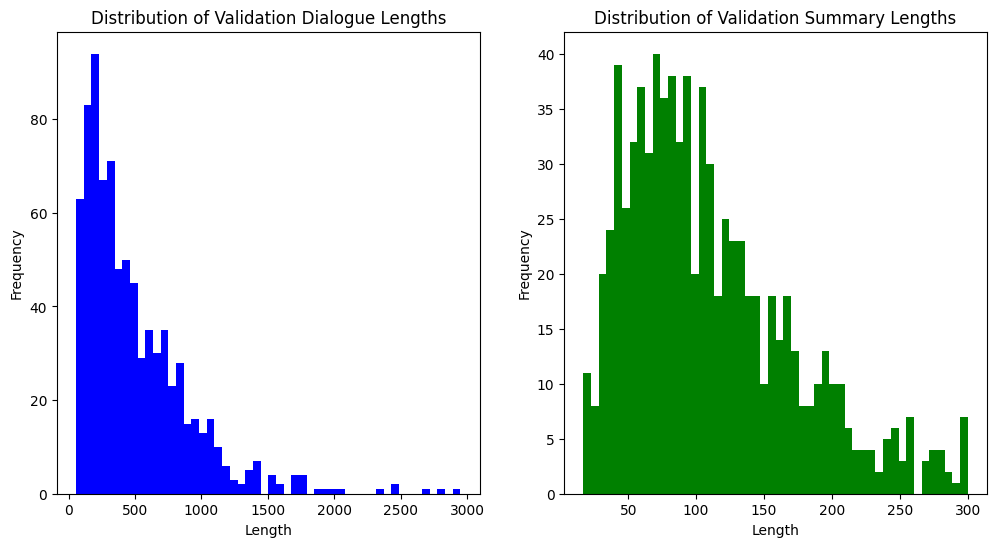

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(validation_dataset['dialogue length'], bins=50, color='blue')
plt.title('Distribution of Validation Dialogue Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(validation_dataset['summary length'], bins=50, color='green')
plt.title('Distribution of Validation Summary Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

**Plotting the length distribution of dialogues and summaries in the testing data.**

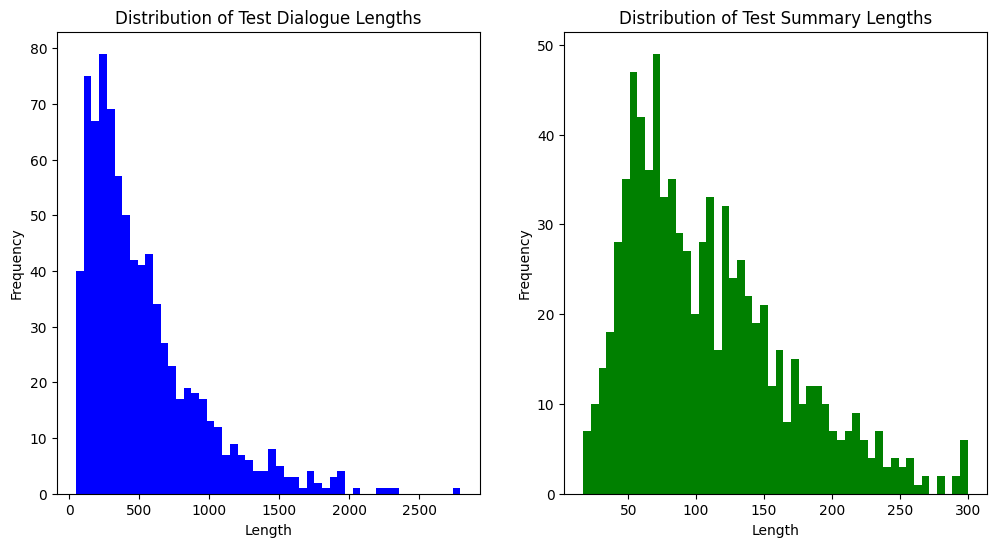

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(test_dataset['dialogue length'], bins=50, color='blue')
plt.title('Distribution of Test Dialogue Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(test_dataset['summary length'], bins=50, color='green')
plt.title('Distribution of Test Summary Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

### 1.3 Finding the correlation between the lengths of the dialogues and the summaries.

In [14]:
train_correlation = train_dataset['dialogue length'].corr(train_dataset['summary length'])
print(f"Correlation between training dialogue and summary: {train_correlation}")
validation_correlation = validation_dataset['dialogue length'].corr(validation_dataset['summary length'])
print(f"Correlation between validation dialogue and summary: {validation_correlation}")
test_correlation = test_dataset['dialogue length'].corr(test_dataset['summary length'])
print(f"Correlation between test dialogue and summary: {test_correlation}")

Correlation between training dialogue and summary: 0.6224545604516943
Correlation between validation dialogue and summary: 0.6067038652956915
Correlation between test dialogue and summary: 0.5941045359946852


**There is a strong positive correlation between the dialogue length and summary length**

#2. Inference with pretrained models

###2.1 Choose at least three pre-trained summarization models from the Hugging Face model hub, such as facebook/bart-large-cnn or t5-large.

In [20]:
# Choosing the below 3 pretrained models from hugging face
bart_model_name = "facebook/bart-large-cnn"
t5_model_name = "google/flan-t5-large"
pegasus_model_name = "google/pegasus-large"

In [21]:
#Loading the required tokenizers and models from hugging face
bart_tokenizer = AutoTokenizer.from_pretrained(bart_model_name)
bart_model = AutoModelForSeq2SeqLM.from_pretrained(bart_model_name)

t5_tokenizer = AutoTokenizer.from_pretrained(t5_model_name)
t5_model = AutoModelForSeq2SeqLM.from_pretrained(t5_model_name)

pegasus_tokenizer = AutoTokenizer.from_pretrained(pegasus_model_name)
pegasus_model = AutoModelForSeq2SeqLM.from_pretrained(pegasus_model_name)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###2.2 Use the models to generate summaries for a few randomly selected dialogues. Analyze the quality of these summaries: Are they coherent? Do they capture the essential points in the conversation?

In [22]:
#Function to generate summary from the given input
def generate_summary(model, tokenizer, input_text):
  # Tokenize the input
  input_ids = tokenizer.encode(input_text, return_tensors='pt')
  # Generate the summary using the model
  summary_ids = model.generate(input_ids, max_length = 200, min_length = 10, num_beams=2, length_penalty=2.0, early_stopping=True)
  # Decode the generated summary
  summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
  return summary

**Selecting random dialogues from train, test and validation dataset to summarize using the pretrained models.**

In [25]:
#Selecting 5 dialogues randomly from each split
train_dialogues_random = train_dataset.sample(n=5, random_state=17)
test_dialogues_random = test_dataset.sample(n=5, random_state=17)
validation_dialogues_random = validation_dataset.sample(n=5, random_state=17)

**Generating summaries using the 3 pretrained models for the selected dialogues from the training dataset.**

In [24]:
# Creating a dictionary to store summaries
train_summary_dict = {}

for index, row in train_dialogues_random.iterrows():
    dialogue = row['dialogue']
    print(f"\n Dialogue:\n {row['dialogue']}")
    original_summary = row['summary']
    print(f"\n Original Summary from dataset:\n {row['summary']}")

    bart_summary = generate_summary(bart_model, bart_tokenizer, dialogue)
    print("\nSummary from bart: \n")
    print(bart_summary)

    t5_summary = generate_summary(t5_model, t5_tokenizer, dialogue)
    print("\nSummary from t5: \n")
    print(t5_summary)

    pegasus_summary = generate_summary(pegasus_model, pegasus_tokenizer, dialogue)
    print("\nSummary from pegasus: \n")
    print(pegasus_summary)

    train_summary_dict[original_summary] = {
        'BART': bart_summary,
        'T5': t5_summary,
        'Pegasus': pegasus_summary
    }


 Dialogue:
 Abigail: Have you thought about what you might like to do this weekend?
Brittany: I have no idea, you?
Abigail: If the weather stays nice, I'd like to go to the beach.
Brittany: That would be a good choice. The weather has been great for the beach!
Abigail: Why don't you come with me?
Brittany: Hey, that would be perfect! What time are you leaving?
Abigail: I think that Saturday morning around 9:30 would work out well.
Brittany: There is going to be a music festival on the beach that day. We would have enough time to drop in and see it.
Abigail: Yes, I heard about that. Let's check it out!

 Original Summary from dataset:
 Abigail and Brittany agreed on going to a music festival on the beach on Saturday.

Summary from bart: 

Abigail asks her boyfriend what he wants to do this weekend. He says he'd like to go to the beach. She suggests a music festival on the beach that day.

Summary from t5: 

Abigail and Brittany will go to the beach on Saturday around 9:30. They will se

**Generating summaries using the 3 pretrained models for the selected dialogues from the validation dataset.**

In [25]:
for index, row in validation_dialogues_random.iterrows():
  print(f"\n Dialogue:\n {row['dialogue']}")
  print(f"\n Original Summary from dataset:\n {row['summary']}")
  print("\nSummary from bart: \n")
  print("\nSummary from bart: \n")
  print(generate_summary(bart_model, bart_tokenizer, row['dialogue']))
  print("\nSummary from t5: \n")
  print(generate_summary(t5_model, t5_tokenizer, row['dialogue']))
  print("\nSummary from pegasus: \n")
  print(generate_summary(pegasus_model, pegasus_tokenizer, row['dialogue']))


 Dialogue:
 Helen: Oh hey there. How do you like Morocco ?
Josh: It's cool. We are on the way to Tanger
Helen: Have fun and take care of Youssef. Don’t let him drive too fast lol

 Original Summary from dataset:
 Josh has fun in Morocco. He's on the way to Tanger.

Summary from bart: 


Summary from bart: 

Helen: Have fun and take care of Youssef. Don’t let him drive too fast lol

Summary from t5: 

Josh is in Morocco and is on his way to Tanger.

Summary from pegasus: 

We are on the way to Tanger Helen: Have fun and take care of Youssef.

 Dialogue:
 Robin: Dad, can you give me a lift?
Mr. Cheng: Sure. When?
Robin: Tonight to the mall.
Mr. Cheng: No problem. Meeting friends?
Robin: No, just need to buy new jeans. Old ones got ripped.
Mr. Cheng: I'll come with you.

 Original Summary from dataset:
 Mr. Cheng will drive Robin to the mall to buy new jeans.

Summary from bart: 


Summary from bart: 

Robin asks his father to give him a lift to the mall.

Summary from t5: 

Mr. Cheng wi

**Generating summaries using the 3 pretrained models for the selected dialogues from the testing dataset.**

In [26]:
for index, row in test_dialogues_random.iterrows():
  print(f"\n Dialogue:\n {row['dialogue']}")
  print(f"\n Original Summary from dataset:\n {row['summary']}")
  print("\nSummary from bart: \n")
  print(generate_summary(bart_model, bart_tokenizer, row['dialogue']))
  print("\nSummary from t5: \n")
  print(generate_summary(t5_model, t5_tokenizer, row['dialogue']))
  print("\nSummary from pegasus: \n")
  print(generate_summary(pegasus_model, pegasus_tokenizer, row['dialogue']))


 Dialogue:
 Kirsten: Youth group this Friday, don't be late.
Alex: What time?
Kirsten: 7 pm. We're going bowling, so we'll meet up and then all go together.
Alex: Cool. See you.
Kirsten: Bye

 Original Summary from dataset:
 Kirsten reminds Alex that the youth group meets this Friday at 7 pm and go bowling.

Summary from bart: 

Kirsten: Youth group this Friday, don't be late.

Summary from t5: 

Alex and Kirsten are going bowling on Friday at 7 pm.

Summary from pegasus: 

Kirsten: 7 pm. Alex: Cool.

 Dialogue:
 Joseph: U there, mate?
Albert: Yeah
Joseph: Damn, I'm tired af
Albert: Why?
Joseph: Had three job interviews in two days
Albert: Ouch! So... any impressions?
Joseph: I think the first two were more than ok, they seemed really satisfied with my résumé, heh, guess I'll have to choose one
Albert: Were both interviews for jobs at hotels?
Joseph: Yeah, I guess I'm gonna be a concierge until the day I die
Albert: O la la! A concierge! With his résumé!
Joseph: What's so funny about 

**Analysing 1 example to compare the summaries generated by all the 3 pretrained models.**

**Dialogue:**

 Rosie: What's your favorite b-movie?

Elle: um, hard to say. Why do you ask?

Dennis: Toxic avenger for sure

Rosie: I have to write an essay and I chose bad movies as my topic and I'm just
looking for inspiration

Elle: plan 9 from outer space is definitely something worth mentioning

Rosie: Yeah, I've seen it. And I will also cover "The Room". I'm just looking for something a bit more niche

Dennis: There's Troma Studio for ya - toxic avenger, poultrygeist - the latter is exceptionally awful - and it's a musical

Rosie: Is it one of those intentionally bad movies?

Dennis: most definitely

Rosie: ok, thank you, I'll check it out

Elle: oh, there's also jesus christ vampire hunter

Rosie: what? :D

Elle: it's even worse than it sounds

Dennis: and when it comes to more recent movies there are those stupid animal-based horror movies like sharknado or zombeavers

Rosie: I've heard of sharknado and zombeavers sound just awesome

Rosie: thanks guys, you helped me a lot :)

**Original Summary from dataset:**

Dennis and Elle are helping Rosie think of bad movies for her essay.

**Summary from bart:**

Rosie is writing an essay about bad movies. She asked her friends to suggest some of their favorite b- movies.

**Summary from t5:**

Rosie has to write an essay about bad movies. Elle recommends Plan 9 from outer space, The Room and Toxic Avenger. Dennis recommends Troma Studio, Toxic Avenger, Poultrygeist and Jesus Christ Vampire Hunter.

**Summary from pegasus:**

Dennis: Toxic avenger for sure Rosie: I have to write an essay and I chose bad movies as my topic and I'm just looking for inspiration Elle: plan 9 from outer space is definitely something worth mentioning Rosie: Yeah, I've seen it.


**Calculating RougeL scores for all the 3 summaries from the training data**

In [31]:
# Function to calculate ROUGEL scores
def calculate_rouge_scores(original, generated):
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = rouge.score(original, generated)
    return rouge_scores['rougeL'][2] #returning the fmeasure of the RougeL score

In [54]:
for original_summary, generated_summaries in train_summary_dict.items():
    print("\nOriginal Summary:", original_summary)

    # Calculate ROUGE scores for each model
    for model_name, summary in generated_summaries.items():
        rouge_scores = calculate_rouge_scores(original_summary, summary)
        print(f"ROUGE Scores for {model_name}:", rouge_scores)



Original Summary: Abigail and Brittany agreed on going to a music festival on the beach on Saturday.
ROUGE Scores for BART: 0.3913043478260869
ROUGE Scores for T5: 0.5945945945945945
ROUGE Scores for Pegasus: 0.28571428571428575

Original Summary: Sylvia reminds Howard that he should take his pills.
ROUGE Scores for BART: 0.1311475409836066
ROUGE Scores for T5: 0.43478260869565216
ROUGE Scores for Pegasus: 0.125

Original Summary: Julie asked Jack to buy the Daily Mail on his way home.
ROUGE Scores for BART: 0.38888888888888895
ROUGE Scores for T5: 0.761904761904762
ROUGE Scores for Pegasus: 0.2222222222222222

Original Summary: Adam allows John to leave work early today because he has completed his tasks for this week and sent a report to Peter and Ted from Accounting.
ROUGE Scores for BART: 0.3170731707317073
ROUGE Scores for T5: 0.39285714285714285
ROUGE Scores for Pegasus: 0.20512820512820512

Original Summary: Kelly wants Peggie to call her as soon as possible. 
ROUGE Scores for 

**Here we can see that the T5 model has the highest RougeL score for each summary while Pegasus model has the lowest. Choosing Pegasus model to finetune further and check if its ROUGE score improves.**

#3. Fine Tuning

###3.1.1 Choosing one of the pre-trained summarization models from the previous part.


In [5]:
#Defining the model name
model_name = "google/pegasus-large"

In [6]:
#Defining the tokenizer for the pegasus model
tokenizer_finetune = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [7]:
#Defining the model
model_finetune = AutoModelForSeq2SeqLM.from_pretrained(model_name)

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

###3.1.2 Preprocess the dataset to fit it to the input format required by the chosen model, which may include tokenizing the dialogues and their summaries

In [8]:
# Function to tokenize the dialogues and summaries
def tokenize(example):
  model_inputs = tokenizer_finetune(example['dialogue'], truncation=True, padding=True, return_tensors = 'pt')
  labels = tokenizer_finetune(example['summary'], truncation=True, padding=True, return_tensors='pt')
  model_inputs['labels'] = labels['input_ids']
  return model_inputs

In [9]:
# Tokenizing all the datasets
tokenized_train_dataset = dataset['train'].map(tokenize, batched=True)
tokenized_validation_dataset = dataset['validation'].map(tokenize, batched=True)
tokenized_test_dataset = dataset['test'].map(tokenize, batched=True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

In [10]:
#Removing the unnecessary columns from the datasets
final_train = tokenized_train_dataset.remove_columns(dataset["train"].column_names)
final_test = tokenized_test_dataset.remove_columns(dataset["test"].column_names)
final_validation = tokenized_validation_dataset.remove_columns(dataset["validation"].column_names)

In [11]:
#Define the training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir = 'pegasus-large-finetune',
    num_train_epochs = 3,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    gradient_accumulation_steps = 16,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    push_to_hub=False,
    predict_with_generate=True,
    logging_steps = 1,
)

In [12]:
#Defining a data collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer_finetune, model=model_finetune)

In [13]:
#Function to calculate the metric - Rouge and Bleu for the generated and actual summaries
def compute_metrics(pred):
    # Decode generated summaries into text
    decoded_preds = tokenizer_finetune.batch_decode(pred.predictions, skip_special_tokens=True)

    # Replace -100 in the labels as they cant be decoded
    labels = np.where(pred.label_ids != -100, pred.label_ids, tokenizer_finetune.pad_token_id)

    # Decode reference summaries into text
    decoded_labels = tokenizer_finetune.batch_decode(labels, skip_special_tokens=True)

    # Adding a newline after each sentence for ROUGE
    decoded_preds_str = "\n".join([" ".join(sent_tokenize(pred.strip())) for pred in decoded_preds])
    decoded_labels_str = "\n".join([" ".join(sent_tokenize(label.strip())) for label in decoded_labels])

    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = rouge.score(decoded_preds_str, decoded_labels_str)

    # BLEU scores
    bleu_scores = corpus_bleu([[ref.split()] for ref in decoded_labels], [pred.split() for pred in decoded_preds])

    # Combine and format the scores
    result = {
        'rouge1': rouge_scores['rouge1'].fmeasure * 100,
        'rouge2': rouge_scores['rouge2'].fmeasure * 100,
        'rougeL': rouge_scores['rougeL'].fmeasure * 100,
        'bleu': bleu_scores * 100
    }

    return result

In [14]:
#Defining the trainer using the above training args and data
trainer = Seq2SeqTrainer(
    model=model_finetune,
    args=training_args,
    train_dataset=final_train,
    eval_dataset=final_validation,
    data_collator=data_collator,
    tokenizer=tokenizer_finetune,
    compute_metrics=compute_metrics
)

In [15]:
# Evaluating the model on validation data before training it, just for comparison later
trainer.evaluate()

{'eval_loss': 10.938543319702148,
 'eval_rouge1': 59.020541485519765,
 'eval_rouge2': 19.82931149501967,
 'eval_rougeL': 20.927932279805855,
 'eval_bleu': 2.9936926033547895,
 'eval_runtime': 1357.9972,
 'eval_samples_per_second': 0.602,
 'eval_steps_per_second': 0.602}

In [16]:
#Training the model on the samsum training data
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Bleu
0,0.613900,0.497111,81.367697,43.958092,40.574587,15.645258
1,0.601600,0.486773,83.428748,44.762170,41.126412,16.464976
2,0.535200,0.484443,83.549006,45.337461,41.774503,16.971953


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 256, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-

TrainOutput(global_step=2760, training_loss=0.955431077958665, metrics={'train_runtime': 9656.5131, 'train_samples_per_second': 4.577, 'train_steps_per_second': 0.286, 'total_flos': 9.128038744753766e+16, 'train_loss': 0.955431077958665, 'epoch': 3.0})

In [17]:
# Evaluate on test data
results = trainer.evaluate(eval_dataset=final_test)

# Print the evaluation results
print(results)

{'eval_loss': 0.4341069459915161, 'eval_rouge1': 83.53391347281368, 'eval_rouge2': 43.6612763856314, 'eval_rougeL': 40.69616737641177, 'eval_bleu': 16.191012021929783, 'eval_runtime': 667.546, 'eval_samples_per_second': 1.227, 'eval_steps_per_second': 1.227, 'epoch': 3.0}


In [26]:
#Saving the trained model
saved_model_path = "/content/pegasus-large-finetune/checkpoint-2760"

In [28]:
#Loading the model and the tokenizer
saved_model = AutoModelForSeq2SeqLM.from_pretrained(saved_model_path)
saved_tokenizer = AutoTokenizer.from_pretrained(saved_model_path)


In [34]:
for index, row in test_dialogues_random.iterrows():
  print(f"\n Dialogue:\n {row['dialogue']}")
  original_summary = row['summary']
  print(f"\n Original Summary from dataset:\n {original_summary}")
  print("\nSummary from pegasus before fine tuning: \n")
  before_summary = generate_summary(pegasus_model, pegasus_tokenizer, row['dialogue'])
  print(before_summary)
  print("\nSummary from pegasus after fine tuning: \n")
  after_summary = generate_summary(saved_model, saved_tokenizer, row['dialogue'])
  print(after_summary)
  print("\n")
  rouge_before = calculate_rouge_scores(original_summary, before_summary)
  print(f"Rouge wrt original summary before finetuning: {rouge_before}")
  rouge_after = calculate_rouge_scores(original_summary, after_summary)
  print(f"Rouge wrt original summary after finetuning: {rouge_after}")


 Dialogue:
 Kirsten: Youth group this Friday, don't be late.
Alex: What time?
Kirsten: 7 pm. We're going bowling, so we'll meet up and then all go together.
Alex: Cool. See you.
Kirsten: Bye

 Original Summary from dataset:
 Kirsten reminds Alex that the youth group meets this Friday at 7 pm and go bowling.

Summary from pegasus before fine tuning: 

Kirsten: 7 pm. Alex: Cool.

Summary from pegasus after fine tuning: 

Kirsten and Alex are going bowling this Friday at 7 pm.


Rouge wrt original summary before finetuning: 0.2857142857142857
Rouge wrt original summary after finetuning: 0.5185185185185185

 Dialogue:
 Joseph: U there, mate?
Albert: Yeah
Joseph: Damn, I'm tired af
Albert: Why?
Joseph: Had three job interviews in two days
Albert: Ouch! So... any impressions?
Joseph: I think the first two were more than ok, they seemed really satisfied with my résumé, heh, guess I'll have to choose one
Albert: Were both interviews for jobs at hotels?
Joseph: Yeah, I guess I'm gonna be a con